In [19]:
import pandas as pd
import numpy as np
%matplotlib inline
#import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import log_loss

In [20]:
train_mean = load_sparse_csr('selectfrommodel_l1_logistic.npz')

In [21]:
datadir = 'input/'
gatrain = pd.read_csv(os.path.join(datadir,'gender_age_train.csv'),
                      index_col='device_id')
gatest = pd.read_csv(os.path.join(datadir,'gender_age_test.csv'),
                     index_col = 'device_id')
phone = pd.read_csv(os.path.join(datadir,'phone_brand_device_model.csv'))
# Get rid of duplicate device ids in phone
phone = phone.drop_duplicates('device_id',keep='first').set_index('device_id')
events = pd.read_csv(os.path.join(datadir,'events.csv'),
                     parse_dates=['timestamp'], index_col='event_id')
appevents = pd.read_csv(os.path.join(datadir,'app_events.csv'), 
                        usecols=['event_id','app_id','is_active'],
                        dtype={'is_active':bool})
applabels = pd.read_csv(os.path.join(datadir,'app_labels.csv'))

In [22]:
gatrain['trainrow'] = np.arange(gatrain.shape[0])
gatest['testrow'] = np.arange(gatest.shape[0])

In [23]:
brandencoder = LabelEncoder().fit(phone.phone_brand)
phone['brand'] = brandencoder.transform(phone['phone_brand'])
gatrain['brand'] = phone['brand']
gatest['brand'] = phone['brand']
Xtr_brand = csr_matrix((np.ones(gatrain.shape[0]), 
                       (gatrain.trainrow, gatrain.brand)))
Xte_brand = csr_matrix((np.ones(gatest.shape[0]), 
                       (gatest.testrow, gatest.brand)))
print('Brand features: train shape {}, test shape {}'.format(Xtr_brand.shape, Xte_brand.shape))

Brand features: train shape (74645, 131), test shape (112071, 131)


In [24]:
m = phone.phone_brand.str.cat(phone.device_model)
modelencoder = LabelEncoder().fit(m)
phone['model'] = modelencoder.transform(m)
gatrain['model'] = phone['model']
gatest['model'] = phone['model']
Xtr_model = csr_matrix((np.ones(gatrain.shape[0]), 
                       (gatrain.trainrow, gatrain.model)))
Xte_model = csr_matrix((np.ones(gatest.shape[0]), 
                       (gatest.testrow, gatest.model)))
print('Model features: train shape {}, test shape {}'.format(Xtr_model.shape, Xte_model.shape))

Model features: train shape (74645, 1667), test shape (112071, 1667)


In [25]:
appencoder = LabelEncoder().fit(appevents.app_id)
appevents['app'] = appencoder.transform(appevents.app_id)
napps = len(appencoder.classes_)
deviceapps = (appevents.merge(events[['device_id']], how='left',left_on='event_id',right_index=True)
                       .groupby(['device_id','app'])['app'].agg(['size'])
                       .merge(gatrain[['trainrow']], how='left', left_index=True, right_index=True)
                       .merge(gatest[['testrow']], how='left', left_index=True, right_index=True)
                       .reset_index())
deviceapps.head()

,device_id,app,size,trainrow,testrow
0,-9222956879900151005,548,18,21594.0,NaN
1,-9222956879900151005,1096,18,21594.0,NaN
2,-9222956879900151005,1248,26,21594.0,NaN
3,-9222956879900151005,1545,12,21594.0,NaN
4,-9222956879900151005,1664,18,21594.0,NaN


In [26]:
d = deviceapps.dropna(subset=['trainrow'])
Xtr_app = csr_matrix((np.ones(d.shape[0]), (d.trainrow, d.app)), 
                      shape=(gatrain.shape[0],napps))
d = deviceapps.dropna(subset=['testrow'])
Xte_app = csr_matrix((np.ones(d.shape[0]), (d.testrow, d.app)), 
                      shape=(gatest.shape[0],napps))
print('Apps data: train shape {}, test shape {}'.format(Xtr_app.shape, Xte_app.shape))

Apps data: train shape (74645, 19237), test shape (112071, 19237)


In [27]:
applabels = applabels.loc[applabels.app_id.isin(appevents.app_id.unique())]
applabels['app'] = appencoder.transform(applabels.app_id)
labelencoder = LabelEncoder().fit(applabels.label_id)
applabels['label'] = labelencoder.transform(applabels.label_id)
nlabels = len(labelencoder.classes_)

In [28]:
devicelabels = (deviceapps[['device_id','app']]
                .merge(applabels[['app','label']])
                .groupby(['device_id','label'])['app'].agg(['size'])
                .merge(gatrain[['trainrow']], how='left', left_index=True, right_index=True)
                .merge(gatest[['testrow']], how='left', left_index=True, right_index=True)
                .reset_index())
devicelabels.head()

,device_id,label,size,trainrow,testrow
0,-9222956879900151005,117,1,21594.0,NaN
1,-9222956879900151005,120,1,21594.0,NaN
2,-9222956879900151005,126,1,21594.0,NaN
3,-9222956879900151005,138,2,21594.0,NaN
4,-9222956879900151005,147,2,21594.0,NaN


In [29]:
d = devicelabels.dropna(subset=['trainrow'])
Xtr_label = csr_matrix((np.ones(d.shape[0]), (d.trainrow, d.label)), 
                      shape=(gatrain.shape[0],nlabels))
d = devicelabels.dropna(subset=['testrow'])
Xte_label = csr_matrix((np.ones(d.shape[0]), (d.testrow, d.label)), 
                      shape=(gatest.shape[0],nlabels))
print('Labels data: train shape {}, test shape {}'.format(Xtr_label.shape, Xte_label.shape))

Labels data: train shape (74645, 492), test shape (112071, 492)


In [31]:
Xtr_app_df = pd.DataFrame(Xtr_app.toarray())

In [33]:
Xtr_app_df.index = gatrain.index

In [34]:
rows1tr = pd.read_csv('data/rows1tr.csv')

In [36]:
index_tr = rows1tr.device_id

In [40]:
Xtr_app_install_sparse = csr_matrix(Xtr_app_df.ix[index_tr])

In [41]:
Xtr_app_install_sparse.shape

(12476, 19237)

In [42]:
train_mean.shape

(12476, 656)

In [43]:
Xtrain = hstack((train_mean, Xtr_app_install_sparse), format='csr')
print('All features: train shape {}'.format(Xtrain.shape))

All features: train shape (12476, 19893)


In [44]:
gatrain_app = gatrain.ix[index_tr]

In [49]:
gatrain_app.shape

(12476, 6)

In [50]:
targetencoder = LabelEncoder().fit(gatrain_app.group)
y = targetencoder.transform(gatrain_app.group)
nclasses = len(targetencoder.classes_)

In [52]:
y.shape

(12476,)

In [58]:
def score(clf, random_state = 24):
    kf = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=random_state)
    pred = np.zeros((y.shape[0],nclasses))
    for itrain, itest in kf:
        Xtr, Xte = Xtrain[itrain, :], Xtrain[itest, :]
        ytr, yte = y[itrain], y[itest]
        clf.fit(Xtr, ytr)
        pred[itest,:] = clf.predict_proba(Xte)
        # Downsize to one fold only for kernels
        #print("{:.5f}".format(log_loss(yte, pred[itest,:])), end=' ')
        #return log_loss(yte, pred[itest, :])
    print('')
    return log_loss(y, pred)

In [59]:
Cs = np.logspace(-3,0,10)
res = []
for C in Cs:
    res.append(score(LogisticRegression(C = C, multi_class='multinomial',solver='lbfgs')))
plt.semilogx(Cs, res,'-o');

KeyboardInterrupt: 

In [55]:
np.logspace(-3,0,10)

array([ 0.001     ,  0.00215443,  0.00464159,  0.01      ,  0.02154435,
        0.04641589,  0.1       ,  0.21544347,  0.46415888,  1.        ])

[ 0.01  0.02  0.03  0.04  0.05  0.06  0.07  0.08  0.09  0.1 ]
1.93001 1.92233 1.93202 1.94493 1.95958 1.97280 1.98790 2.01279 2.03126 2.02842 

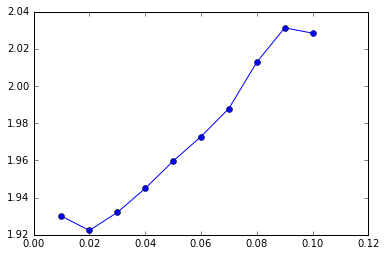

In [57]:
Cs = np.linspace(0.01,0.1,10)
print(Cs)
res = []
for C in Cs:
    res.append(score(LogisticRegression(C = C, multi_class='multinomial',solver='lbfgs')))
plt.plot(Cs, res,'-o');

In [62]:
score(LogisticRegression(C = 0.02, multi_class='multinomial',solver='lbfgs'))

1.9351678353853039

In [63]:
Xtrain = hstack((Xtr_brand, Xtr_model, Xtr_app, Xtr_label), format='csr')
#Xtest =  hstack((Xte_brand, Xte_model, Xte_app, Xte_label), format='csr')
print('All features: train shape {}'.format(Xtrain.shape))

All features: train shape (74645, 21527)


In [64]:
Xtrain_df = pd.DataFrame(Xtrain.toarray())
Xtrain_df.shape

(74645, 21527)

In [65]:
Xtrain_df.index = gatrain.index

In [67]:
Xtrain_df.shape

(74645, 21527)

In [68]:
index_tr.shape

(12476,)

In [69]:
Xtrain_df_app = Xtrain_df.ix[index_tr]

In [71]:
Xtrain_df_app_sparse = csr_matrix(Xtrain_df_app)

In [72]:
Xtrain_df_app_sparse.shape

(12476, 21527)

In [73]:
def score1(clf, random_state = 24):
    kf = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=random_state)
    pred = np.zeros((y.shape[0],nclasses))
    for itrain, itest in kf:
        Xtr, Xte = Xtrain[itrain, :], Xtrain[itest, :]
        ytr, yte = y[itrain], y[itest]
        clf.fit(Xtr, ytr)
        pred[itest,:] = clf.predict_proba(Xte)
        # Downsize to one fold only for kernels
        print("{:.5f}".format(log_loss(yte, pred[itest,:])), end=' ')
        return log_loss(yte, pred[itest, :])
    print('')
    return log_loss(y, pred)

2.48459 2.48450 2.48438 2.48423 2.48404 2.48379 2.48348 2.48308 2.48259 2.48197 

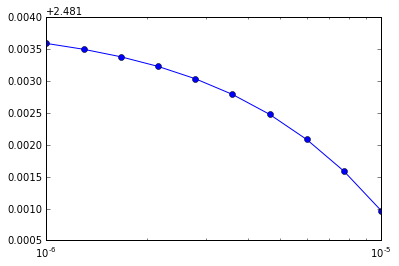

In [81]:
Cs = np.logspace(-6,-5,10)
res = []
for C in Cs:
    res.append(score1(LogisticRegression(C = C,dual=True)))
plt.semilogx(Cs, res,'-o');

In [82]:
events_data = pd.read_hdf('events_data.hdf5','table')

In [83]:
events_data.head()

,event_id,app_id,is_active,device_id,timestamp,longitude,latitude,label_id,category,labels_count
0,2,5927333115845830913,True,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97,"[549, 710, 704, 548, 172]","[Property Industry 1.0, Relatives 1, Property ...",5
1,2,-5720078949152207372,False,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97,"[721, 704, 548, 302, 303]","[Personal Effectiveness 1, Property Industry 2...",5
2,2,-1633887856876571208,False,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97,"[251, 263, 306, 302, 405, 730, 756, 757, 775, ...","[Finance, Debit and credit, unknown, Custom la...",12
3,2,-653184325010919369,True,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97,"[405, 730, 747, 749, 776, 782, 785, 255, 251, ...","[Custom label, And the Church, Insurance, Lowe...",10
4,2,8693964245073640147,True,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97,"[549, 710, 704, 548, 172]","[Property Industry 1.0, Relatives 1, Property ...",5


In [86]:
index_events = (set(gatrain.index)&set(events_data.device_id.unique()))

In [90]:
index_events_series = pd.Series(list(index_events))

In [91]:
index_events_series.shape

(23290,)

In [92]:
Xtrain_df_app = Xtrain_df.ix[index_events_series]

In [99]:
gatrain_app_events = gatrain.ix[index_events_series]

In [101]:
gatrain_app_events.head()

,gender,age,group,trainrow,brand,model
device_id,,,,,,
-1240485184315195386,M,30,M29-31,16666,31,702
2469559569966825478,M,46,M39+,55330,51,860
-3259740179911016439,M,32,M32-38,58069,51,865
-4963191764036878320,M,20,M22-,11549,31,735
-7527017760122470383,M,33,M32-38,7495,31,749


In [100]:
Xtrain_df_app.head()

,0,1,2,3,4,5,6,7,8,9,...,21517,21518,21519,21520,21521,21522,21523,21524,21525,21526
device_id,,,,,,,,,,,,,,,,,,,,,
-1240485184315195386,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2469559569966825478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-3259740179911016439,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
-4963191764036878320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
-7527017760122470383,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [102]:
targetencoder = LabelEncoder().fit(gatrain_app_events.group)
y = targetencoder.transform(gatrain_app_events.group)
nclasses = len(targetencoder.classes_)

In [103]:
Xtrain_df_events_sparse = csr_matrix(Xtrain_df_app)
Xtrain = Xtrain_df_events_sparse

2.12085 2.05635 2.00734 1.97713 1.96922 1.99592 2.05236 2.14716 2.31406 2.33667 

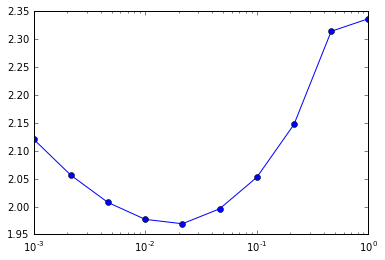

In [104]:
Cs = np.logspace(-3,0,10)
res = []
for C in Cs:
    res.append(score1(LogisticRegression(C = C, multi_class='multinomial',solver='lbfgs')))
plt.semilogx(Cs, res,'-o');

In [105]:
np.logspace(-3,0,10)

array([ 0.001     ,  0.00215443,  0.00464159,  0.01      ,  0.02154435,
        0.04641589,  0.1       ,  0.21544347,  0.46415888,  1.        ])

In [107]:
Xtrain

<23290x21527 sparse matrix of type '<class 'numpy.float64'>'
	with 2605002 stored elements in Compressed Sparse Row format>

In [108]:
Xtr_app_mean = load_sparse_csr('data/xtr_app.npz')

In [109]:
Xtr_app_mean.shape

(74645, 7825)

In [110]:
Xtr_app_mean_df = pd.DataFrame(Xtr_app_mean.toarray())

In [111]:
Xtr_app_mean_df.index = gatrain.index

In [117]:
Xtrain_df_app.head()

,0,1,2,3,4,5,6,7,8,9,...,21517,21518,21519,21520,21521,21522,21523,21524,21525,21526
device_id,,,,,,,,,,,,,,,,,,,,,
-1240485184315195386,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2469559569966825478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-3259740179911016439,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
-4963191764036878320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
-7527017760122470383,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [114]:
index_events_series.shape

(23290,)

In [115]:
Xtr_app_mean_df_split = Xtr_app_mean_df.ix[index_events_series]

In [116]:
Xtr_app_mean_df_split.head()

,0,1,2,3,4,5,6,7,8,9,...,7815,7816,7817,7818,7819,7820,7821,7822,7823,7824
device_id,,,,,,,,,,,,,,,,,,,,,
-1240485184315195386,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2469559569966825478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-3259740179911016439,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-4963191764036878320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-7527017760122470383,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [118]:
Xtrain = hstack((Xtrain, csr_matrix(Xtr_app_mean_df_split)), format='csr')
#Xtest =  hstack((Xte_brand, Xte_model, Xte_app, Xte_label), format='csr')
print('All features: train shape {}'.format(Xtrain.shape))

All features: train shape (23290, 29352)


In [119]:
y.shape

(23290,)

In [120]:
def score(clf, random_state = 24):
    kf = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=random_state)
    pred = np.zeros((y.shape[0],nclasses))
    for itrain, itest in kf:
        Xtr, Xte = Xtrain[itrain, :], Xtrain[itest, :]
        ytr, yte = y[itrain], y[itest]
        clf.fit(Xtr, ytr)
        pred[itest,:] = clf.predict_proba(Xte)
        # Downsize to one fold only for kernels
        print("{:.5f}".format(log_loss(yte, pred[itest,:])), end=' ')
        return log_loss(yte, pred[itest, :])
    print('')
    return log_loss(y, pred)

[ 0.001       0.00215443  0.00464159  0.01        0.02154435  0.04641589
  0.1         0.21544347  0.46415888  1.        ]
2.11815 2.05361 2.00474 1.97573 1.97000 1.99657 2.08645 2.17741 2.35832 2.42965 

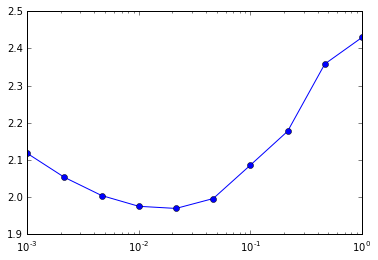

In [121]:
Cs = np.logspace(-3,0,10)
print(Cs)
res = []
for C in Cs:
    res.append(score(LogisticRegression(C = C, multi_class='multinomial',solver='lbfgs')))
plt.semilogx(Cs, res,'-o');

In [122]:
Xtrain.shape

(23290, 29352)